In [1]:
# Standard imports
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specific imports
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, f_regression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Local imports
from src.utils import eda, plot


warnings.filterwarnings("ignore")

- *Preprocessed data*

In [2]:
# Read preprocessed data from file (parquet or csv file)
# Parquet file is preferable as it keeps the original data types
# and it is way more optmized than a csv file
df_preprocessed = pd.read_csv(r"data\dados_preprocessados.csv")

# Check data information
print(df_preprocessed.info())

# Split numerical and categorical features
categorical_features = ["season", "holiday", "workingday"]
numerical_features = df_preprocessed.drop(columns=categorical_features + ["count"]).columns

# Display data
df_preprocessed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17212 entries, 0 to 17211
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   season                    17212 non-null  object 
 1   holiday                   17212 non-null  bool   
 2   workingday                17212 non-null  bool   
 3   hour_sin                  17212 non-null  float64
 4   hour_cos                  17212 non-null  float64
 5   weekday_sin               17212 non-null  float64
 6   weekday_cos               17212 non-null  float64
 7   month_sin                 17212 non-null  float64
 8   month_cos                 17212 non-null  float64
 9   temp_lag_25h              17212 non-null  float64
 10  feel_temp_lag_25h         17212 non-null  float64
 11  humidity_lag_25h          17212 non-null  float64
 12  windspeed_lag_25h         17212 non-null  float64
 13  count_lag_25h             17212 non-null  float64
 14  temp_l

,season,holiday,workingday,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,temp_lag_25h,...,temp_roll_std_168h,feel_temp_roll_mean_168h,feel_temp_roll_std_168h,humidity_roll_mean_168h,humidity_roll_std_168h,windspeed_roll_mean_168h,windspeed_roll_std_168h,count_roll_mean_168h,count_roll_std_168h,count
0,spring,False,False,1.000000,6.123234e-17,-0.781831,0.62349,5.000000e-01,0.866025,9.02,...,3.758320,13.152465,4.347737,0.586597,0.177126,12.028128,7.556756,0.056636,0.051720,0.002047
1,spring,False,False,0.965926,-2.588190e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.762645,13.126146,4.351633,0.585764,0.176348,12.090615,7.493538,0.057119,0.051667,0.009212
2,spring,False,False,0.866025,-5.000000e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.765416,13.099861,4.359961,0.583750,0.175539,12.208656,7.435403,0.058328,0.053295,0.015353
3,spring,False,False,0.707107,-7.071068e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.768177,13.068299,4.372493,0.581458,0.174848,12.347542,7.392424,0.059053,0.053653,0.020471
4,spring,False,False,0.500000,-8.660254e-01,-0.781831,0.62349,5.000000e-01,0.866025,8.20,...,3.769680,13.036736,4.379248,0.578819,0.175154,12.500339,7.362756,0.059408,0.053518,0.062436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17207,spring,False,True,-0.965926,2.588190e-01,0.781831,0.62349,-2.449294e-16,1.000000,9.84,...,1.463892,12.331493,1.969584,0.685903,0.163598,16.035008,10.185871,0.068819,0.070051,0.121801
17208,spring,False,True,-0.866025,5.000000e-01,0.781831,0.62349,-2.449294e-16,1.000000,13.94,...,1.468558,12.315729,1.980343,0.682708,0.163289,16.125318,10.180694,0.069203,0.069924,0.091095
17209,spring,False,True,-0.707107,7.071068e-01,0.781831,0.62349,-2.449294e-16,1.000000,9.02,...,1.480957,12.305208,1.985408,0.679792,0.162590,16.139230,10.172251,0.069373,0.069841,0.092119
17210,spring,False,True,-0.500000,8.660254e-01,0.781831,0.62349,-2.449294e-16,1.000000,8.20,...,1.493166,12.284167,1.995305,0.677153,0.161582,16.187805,10.140161,0.069473,0.069784,0.062436


- *[Time Series cross-validation][]*

[Time Series cross-validation]: https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split

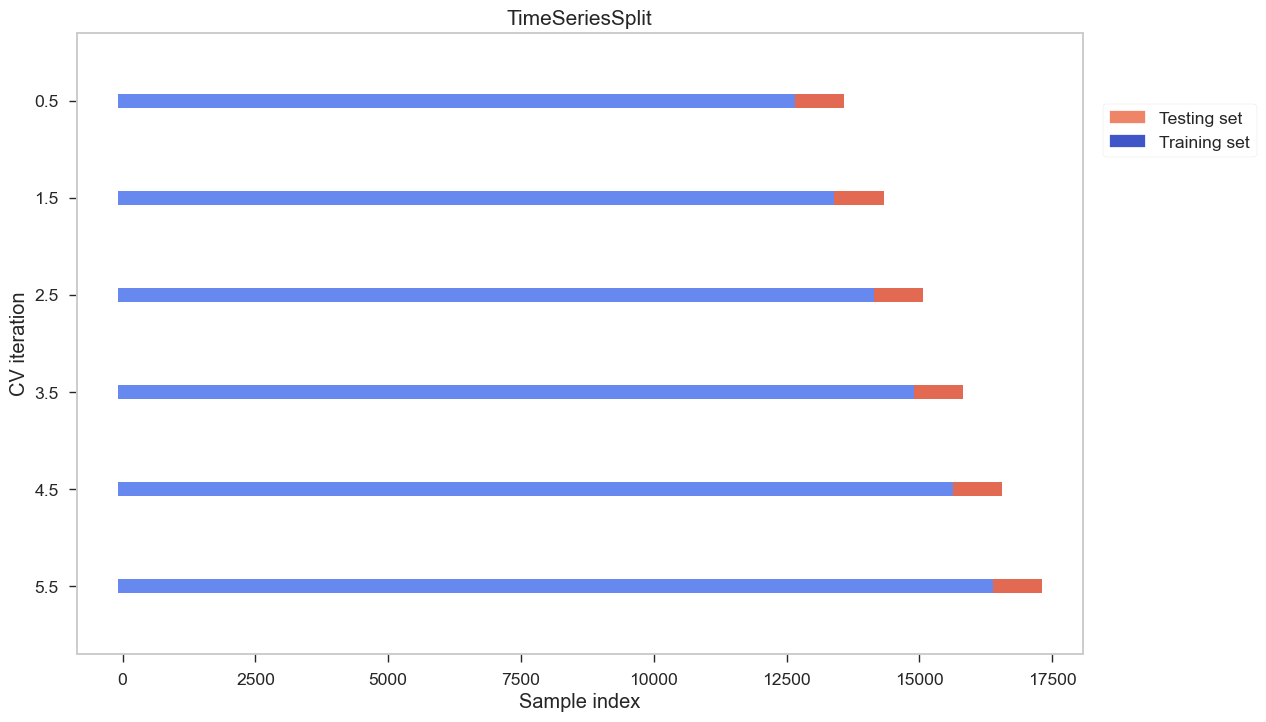

In [3]:
# Time Series cross-validator
# Provides train/test indices to split time series data samples 
# that are observed at fixed time intervals, in train/test sets.
X =  df_preprocessed.drop(columns=["count"])
y =  df_preprocessed["count"]

# Times Series Cross Validator Object
tss = TimeSeriesSplit(n_splits=6, test_size=24 * 31)

# Visualize split
eda.plot_cv_indices(X, y, tss, 6)

- *Evaluate Features*

<Axes: >

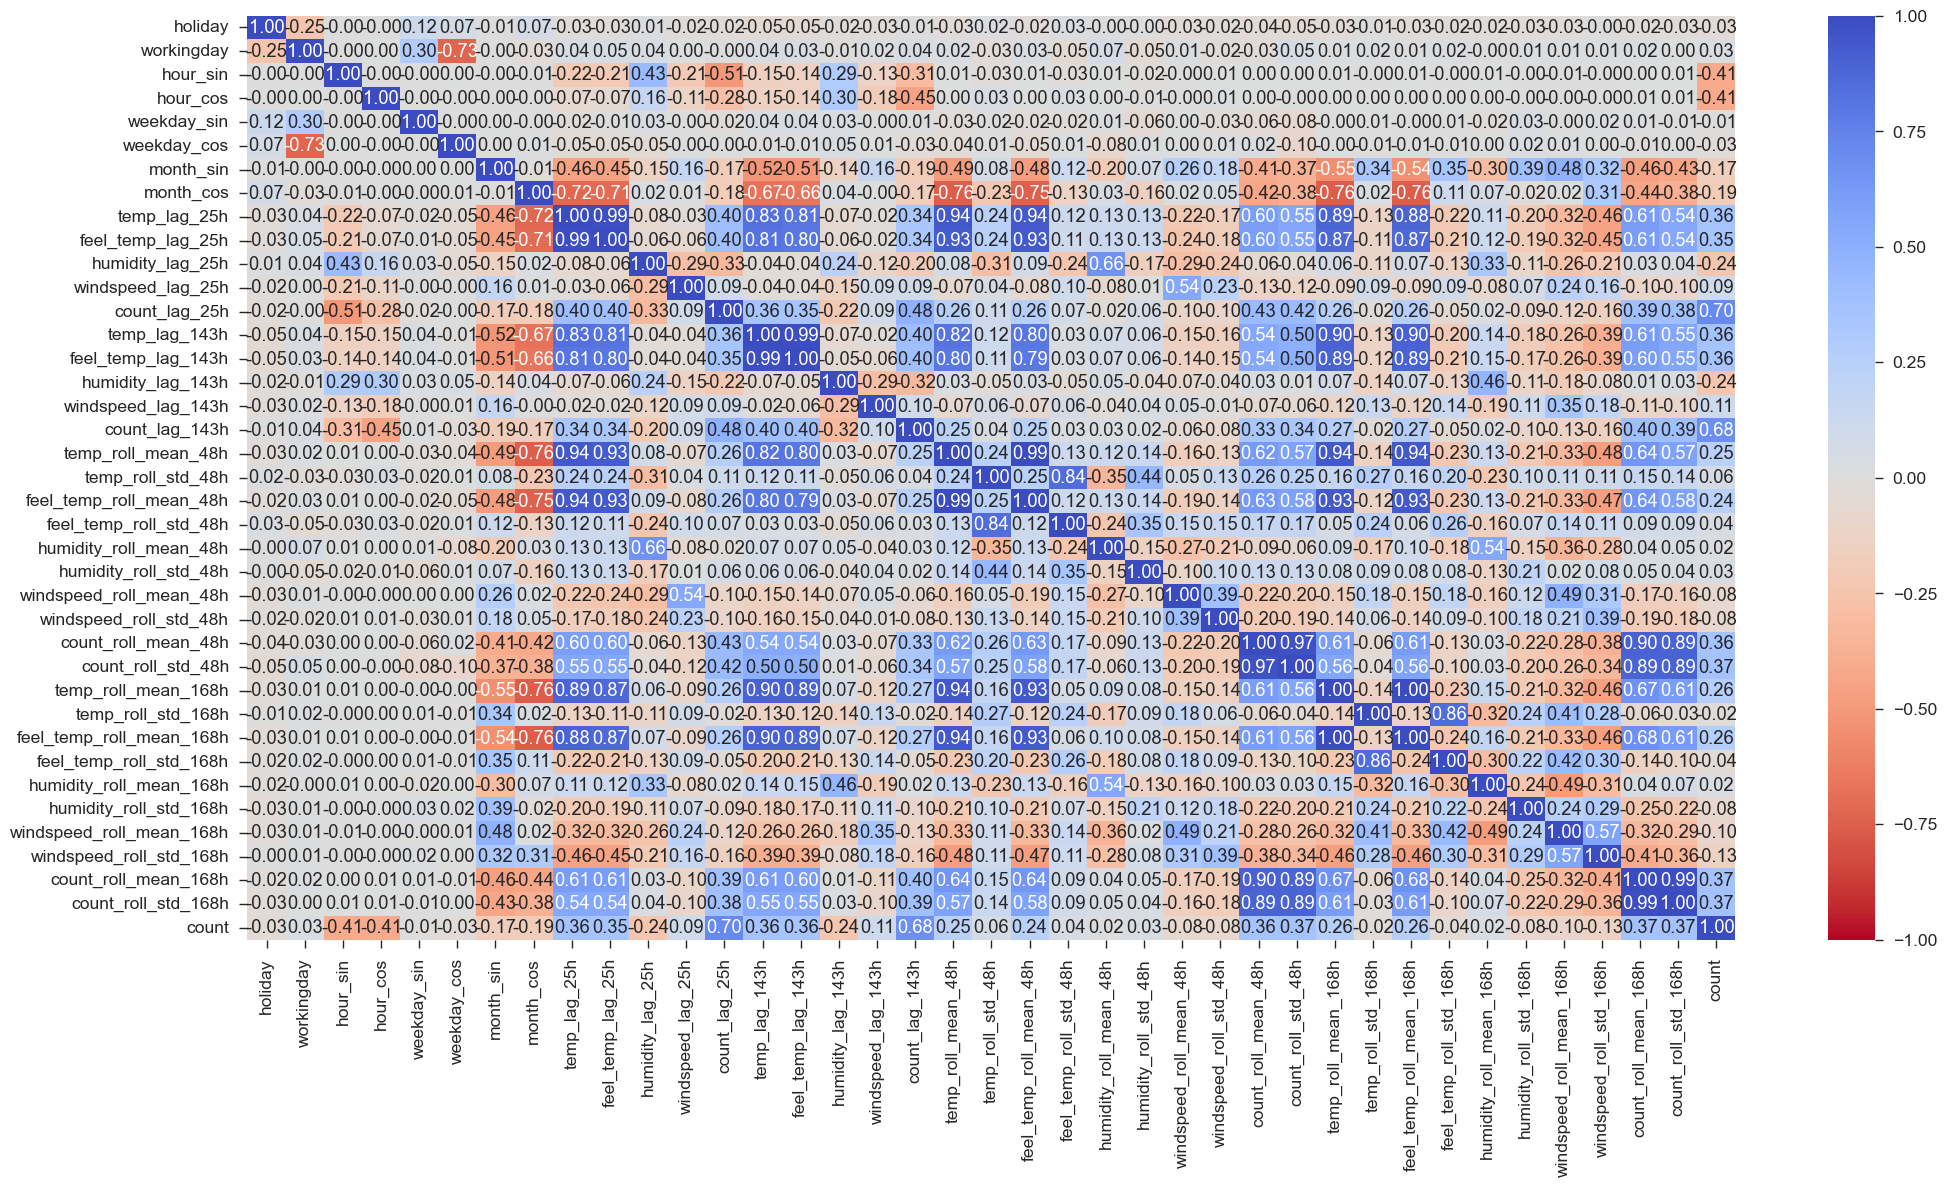

In [4]:
fig, ax = plt.subplots(figsize=(24, 12))

# Linear correlations (pearson)
sns.heatmap(
    df_preprocessed.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm_r",
    ax=ax,
    fmt=".2f",
)

Features selected (50 %) :

         Index(['hour_sin', 'hour_cos', 'temp_lag_25h', 'feel_temp_lag_25h',
       'humidity_lag_25h', 'count_lag_25h', 'temp_lag_143h',
       'feel_temp_lag_143h', 'humidity_lag_143h', 'count_lag_143h',
       'temp_roll_mean_48h', 'feel_temp_roll_mean_48h', 'count_roll_mean_48h',
       'count_roll_std_48h', 'temp_roll_mean_168h', 'feel_temp_roll_mean_168h',
       'count_roll_mean_168h', 'count_roll_std_168h'],
      dtype='object')


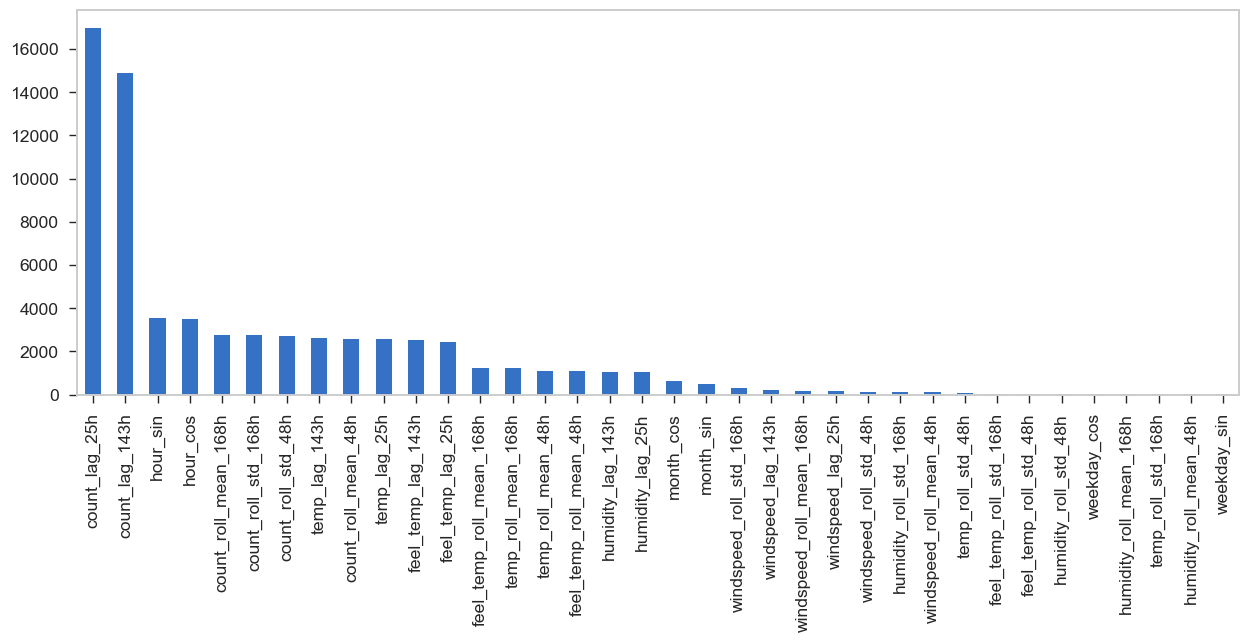

In [5]:
# Linear features importance
eda.feature_selection(X[numerical_features], y, percentile=50)

Features selected (10 %) :

         Index(['hour_sin', 'hour_cos', 'count_lag_25h', 'count_lag_143h'], dtype='object')


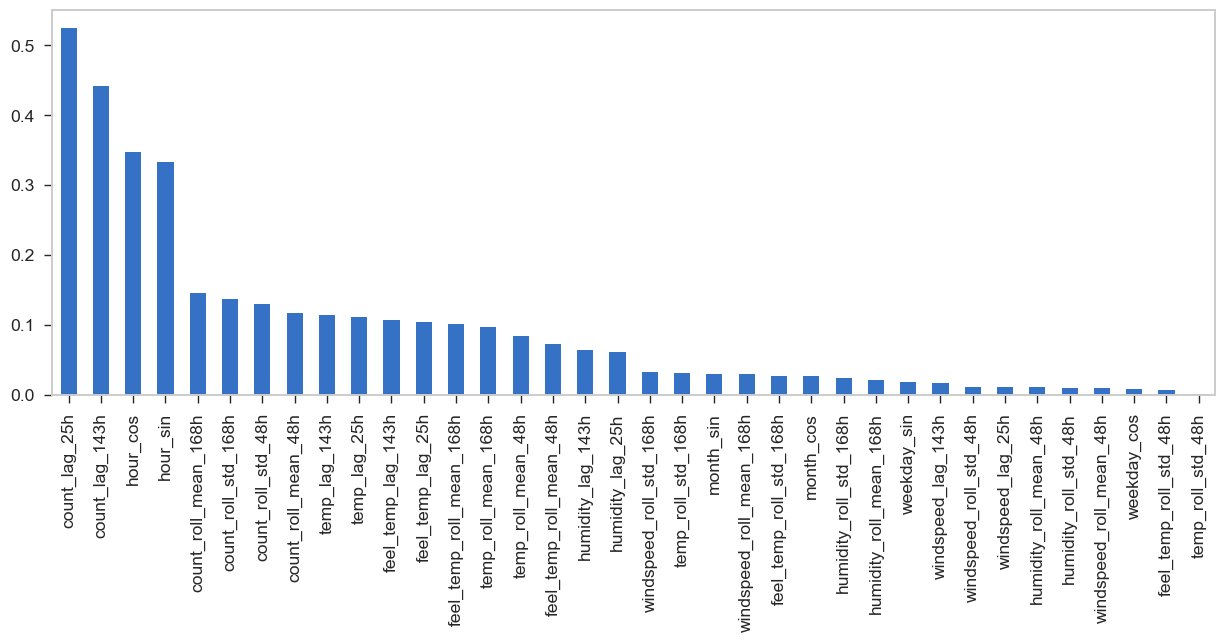

In [6]:
# Non-linear features importance
eda.feature_selection(X[numerical_features], y, percentile=10, method="non-linear")

- *Evaluate models*

In [7]:
# ----- Preprocessors -----
# 1) Preprocessor for models that require One-Hot or numeric-only input (linear, tree-with-OHE)
preprocessor_ohe = ColumnTransformer(transformers=[("num", StandardScaler(), numerical_features),
                                                   ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
])

# 2) Preprocessor for models that accept integer-encoded categories (HistGradientBoosting)
#    We encode categories as integer labels (OrdinalEncoder), and scale numerics.
#    HistGB works well when categories are integer-coded, and numerics are scaled.
preprocessor_hgb = ColumnTransformer(
    transformers=[
        ("num", StandardScaler() , numerical_features),
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            ,
            categorical_features,
        ),
    ],
    remainder="drop",
)

# 3) Preprocessor for neural nets (min-max scaling often helps activations)
preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    remainder="drop",
)

In [8]:
# ----- Estimator Pipelines -----
model_configs = {
    # Linear models (explicit feature selection can help reduce collinearity / noise)
    "RIDGE": Pipeline([("preproc", preprocessor_ohe), ("feat_sel", "passthrough"), ("reg", RidgeCV(cv=tss, scoring="neg_mean_squared_error"))]),
    "LASSO": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", SelectPercentile(score_func=f_regression, percentile=60)),
            ("reg", LassoCV(random_state=42, max_iter=10_000, cv=tss)),
        ]
    ),
    "ENET": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", SelectPercentile(score_func=f_regression, percentile=60)),
            (
                "reg",
                ElasticNetCV(
                    cv=tss, random_state=42, l1_ratio=[0.1, 0.5, 0.9], max_iter=10_000
                ),
            ),
        ]
    ),
    # Neural networks (benefit from reduced feature space)
    "NN": Pipeline(
        [
            ("preproc", preprocessor_nn),
            # ("feat_sel", ),
            (
                "reg",
                MLPRegressor(
                    random_state=42,
                    solver="adam",
                    hidden_layer_sizes=(30, 15),
                    activation="relu",
                    learning_rate_init=1e-3,
                    early_stopping=True,
                    validation_fraction=0.1,
                    alpha=1e-4,
                    max_iter=2000,
                    tol=1e-4,
                ),
            ),
        ]
    ),
    # Tree ensembles
    "RF": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", ),
            (
                "reg",
                RandomForestRegressor(
                    random_state=42,
                    n_estimators=300,
                    max_depth=10,
                    max_features="sqrt",
                    # n_jobs=-1,
                ),
            ),
        ]
    ),
    "XG": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", ),
            (
                "reg",
                XGBRegressor(
                    random_state=42,
                    n_estimators=500,
                    learning_rate=0.05,
                    max_depth=4,
                    colsample_bytree=0.8,
                    subsample=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    # n_jobs=-1,
                    verbosity=0,
                ),
            ),
        ]
    ),
    "LGBM": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", ),
            (
                "reg",
                LGBMRegressor(
                    random_state=42,
                    n_estimators=1000,
                    learning_rate=0.05,
                    num_leaves=31,
                    colsample_bytree=0.8,
                    subsample=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    # n_jobs=-1,
                    verbosity=-1,
                ),
            ),
        ]
    ),
    # HistGB (native categorical support, skip explicit FS)
    "HGB": Pipeline(
        [
            ("preproc", preprocessor_hgb),
            # ("feat_sel", ),
            (
                "reg",
                HistGradientBoostingRegressor(
                    random_state=42, max_iter=1000, max_depth=10, learning_rate=0.05
                ),
            ),
        ]
    ),
}
# Convert config to list for your loop
models = list(model_configs.items())

In [ ]:
# Lower MAPE
plot.plot_cross_val_scores(
    models=models,
    X=X,
    y=y,
    scaler=None,
    cv=tss,
    scoring="neg_mean_absolute_error",
)

RIDGE: -0.093172 (0.008721)


NN: 0.808309 (0.043714)
RF: 0.733283 (0.056201)
XG: 0.815091 (0.045459)
LGBM: 0.823377 (0.058416)
HGB: 0.823732 (0.048395)


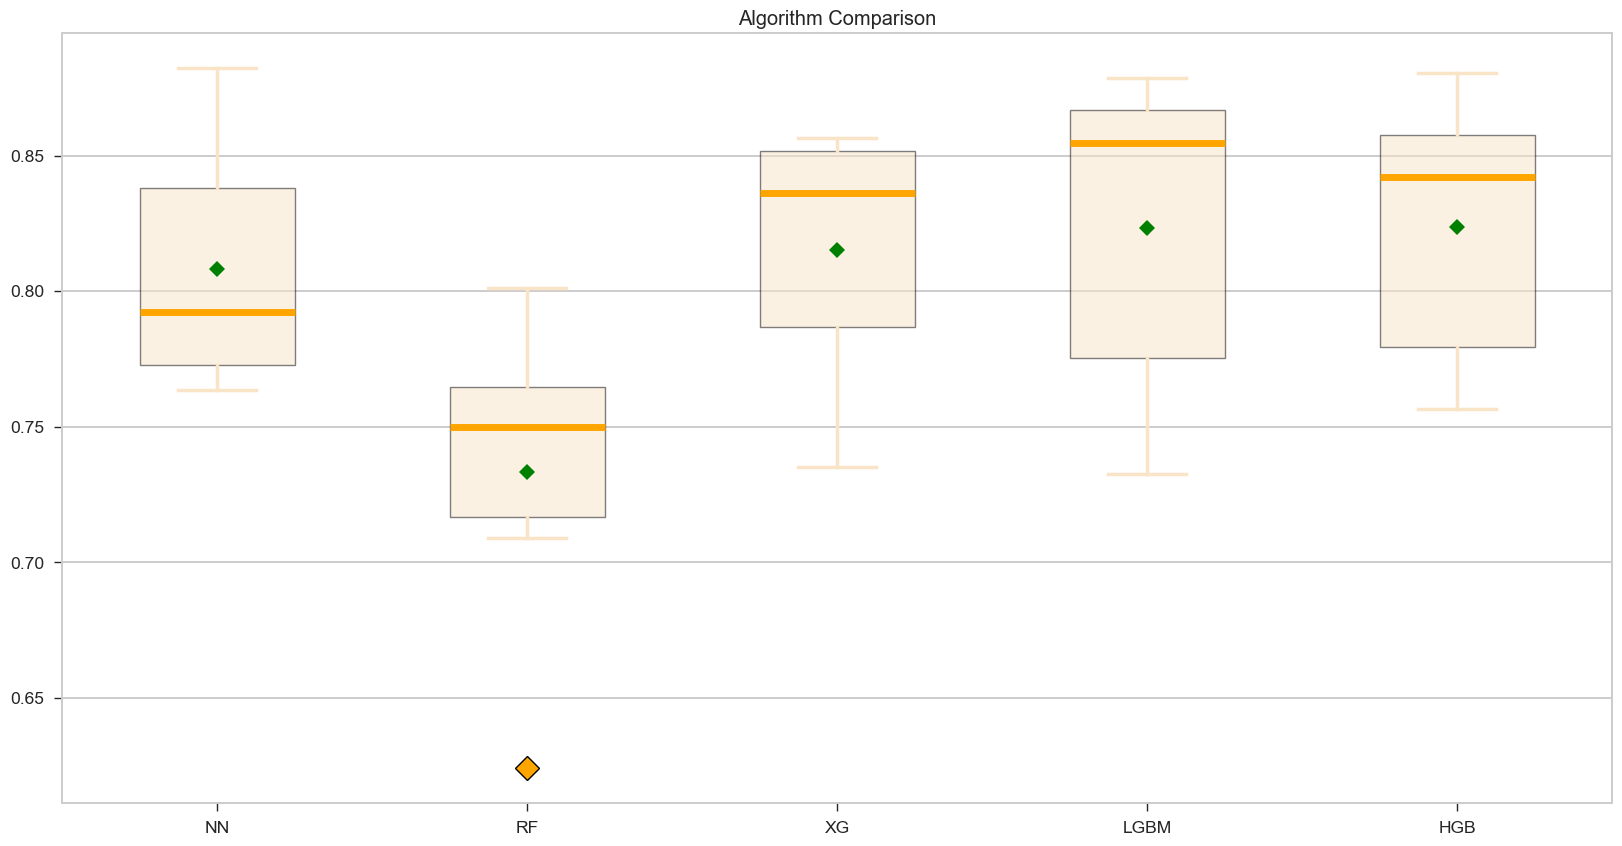

In [ ]:
# Higher R²
plot.plot_cross_val_scores(
    models=models[3:],
    X=X,
    y=y,
    scaler=None,
    cv=tss,
    scoring="r2",
)